# Plots for ablation study of data augmentation

In [16]:
import utils
import model
import matplotlib.pyplot as plt
import torch
import numpy as np

In [2]:
dataset_name = 'facades'

In [17]:
# instantiate datasets and dataloaders
datasets = {'train': utils.ImageDataset(dataset_name = dataset_name, transform=utils.data_transforms['train'], mode = 'train'),
            'val': utils.ImageDataset(dataset_name = dataset_name, transform=None, mode = 'val')
}
dataloaders = {'train': utils.DataLoader(datasets['train'], batch_size=1, shuffle=False),
                    'val': utils.DataLoader(datasets['val'], batch_size=1, shuffle=False)}

In [14]:
# load model
p2p = model.Pix2Pix().to(utils.device)

In [53]:
# get training and validation inputs
input_train, real_train = datasets['train'].__getitem__(1)
input_val, real_val = datasets['val'].__getitem__(23)

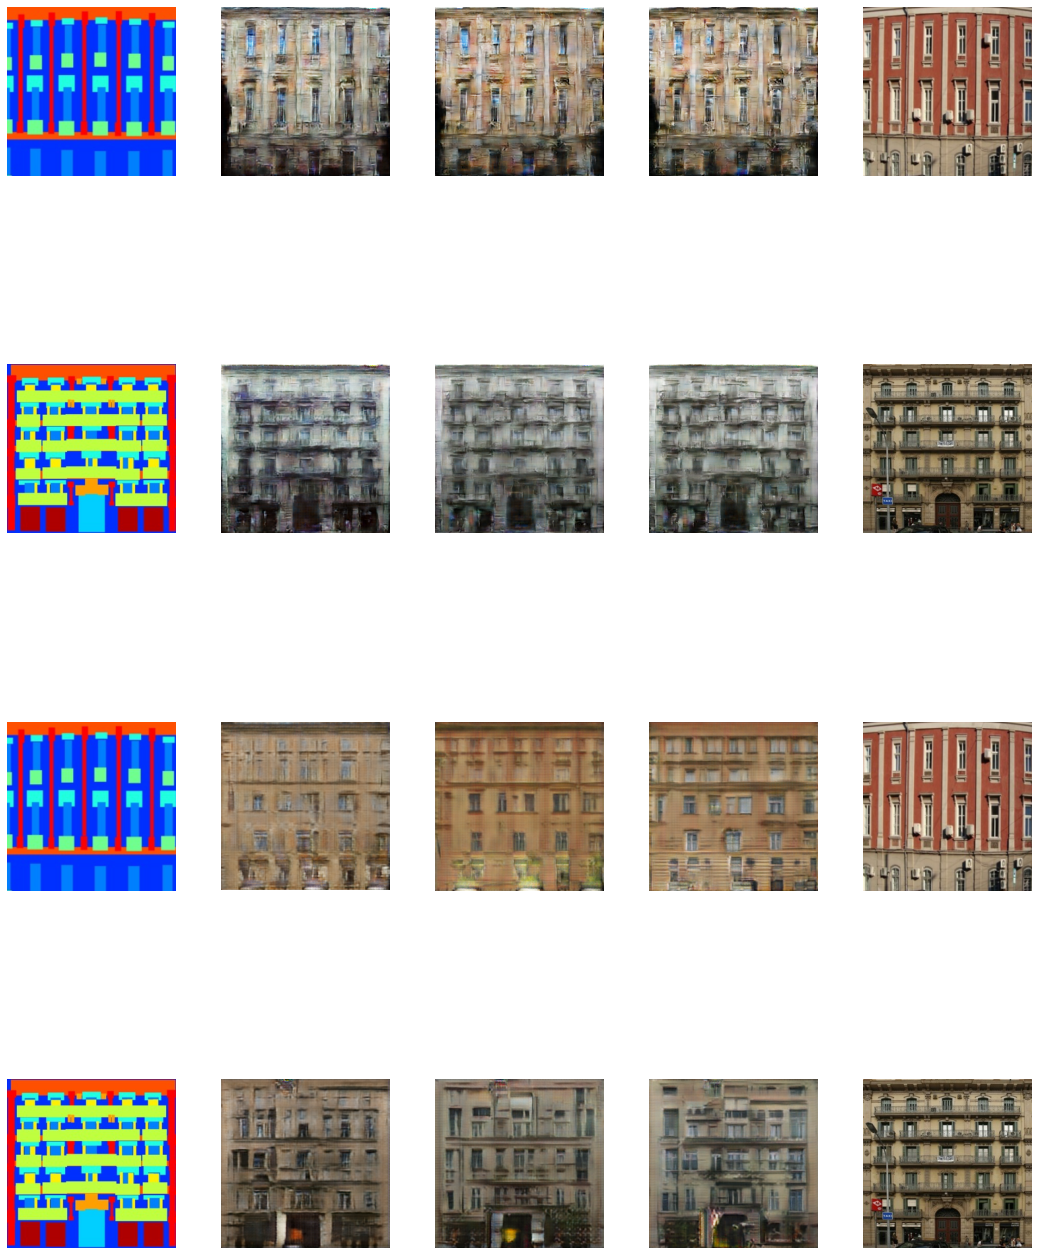

In [71]:
fig, axs = plt.subplots(nrows = 4, ncols = 5, figsize=(15,20))
plt.tight_layout()

# disable all axis
for ax in axs.flatten(): 
    ax.axis('off')

axs[0, 0].imshow(np.clip(input_train.permute(1,2,0).detach().cpu().numpy(), 0, 1))
axs[1, 0].imshow(np.clip(input_val.permute(1,2,0).detach().cpu().numpy(), 0, 1))
axs[2, 0].imshow(np.clip(input_train.permute(1,2,0).detach().cpu().numpy(), 0, 1))
axs[3, 0].imshow(np.clip(input_val.permute(1,2,0).detach().cpu().numpy(), 0, 1))

axs[0, 4].imshow(np.clip(real_train.permute(1,2,0).detach().cpu().numpy(), 0, 1))
axs[1, 4].imshow(np.clip(real_val.permute(1,2,0).detach().cpu().numpy(), 0, 1))
axs[2, 4].imshow(np.clip(real_train.permute(1,2,0).detach().cpu().numpy(), 0, 1))
axs[3, 4].imshow(np.clip(real_val.permute(1,2,0).detach().cpu().numpy(), 0, 1))

for i, da_mode in enumerate(['', 'da_']):
        for k, ep in enumerate(range(79,200,60)):
            p2p.load_state_dict(torch.load(utils.weights_path + '/' + 'facades_long_' + da_mode + 'ep' + str(ep) + '.pkl'))
            for j, mode in enumerate(['train', 'val']):
                pred_train = p2p.generator(input_train.to(utils.device)[None, :])[0]
                pred_val = p2p.generator(input_val.to(utils.device)[None, :])[0]
                axs[2*i, 1 + k].imshow(np.clip(pred_train.permute(1,2,0).detach().cpu().numpy(), 0, 1))
                axs[2*i + 1, 1 + k].imshow(np.clip(pred_val.permute(1,2,0).detach().cpu().numpy(), 0, 1))
